In [28]:
import sklearn
from skimage import io
import skimage
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.filters import try_all_threshold
from pathlib import Path
import pandas as pd
import datetime
import imageio.v2 as imageio
import PIL.Image


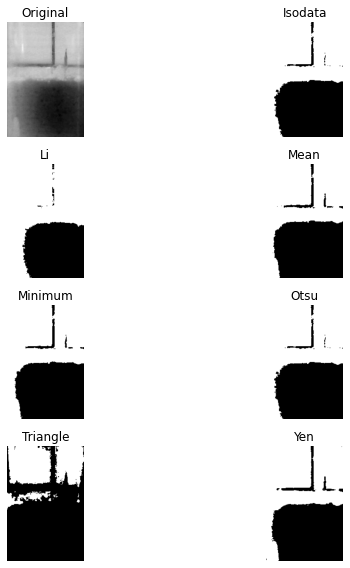

In [29]:
img = skimage.io.imread('/mnt/open-sourdough/images/1/2023-02-19_06-47-12-396459.jpg',as_gray=True)
# img = skimage.io.imread('/mnt/open-sourdough/images/1/2023-02-19_03-31-49-002567.jpg',as_gray=True)
# print(img.shape)
img = img[100:340, 240:400]   # crop image to zoom in to jar

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

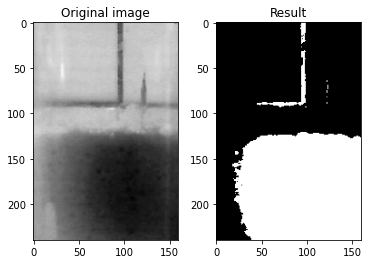

In [30]:
from skimage.filters import threshold_minimum

thresh = threshold_minimum(img, nbins=10)
binary_img = img < thresh

fig, axes = plt.subplots(ncols=2)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary_img, cmap=plt.cm.gray)
ax[1].set_title('Result')

plt.show()

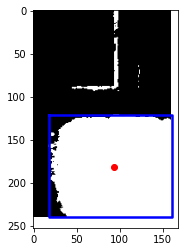

In [31]:
from skimage.measure import label, regionprops
height = None

fig, ax = plt.subplots()
ax.imshow(binary_img, cmap=plt.cm.gray)

label_img = label(binary_img)
regions = regionprops(label_img)

min_area = 5000

for props in regions:
    y0, x0 = props.centroid

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)

    area = (maxc-minc)*(maxr-minr)
    
    if area >= min_area:
        # Plot the bounding box
        ax.plot(bx, by, '-b', linewidth=2.5)
        # Plot the centroid
        ax.plot(x0, y0, 'ro')
        height = minr

plt.show()

In [32]:
height

121

In [33]:
def get_heights(base_dir):
    heights = []
    time = []
    name = []
    for img_path in sorted(base_dir.glob("*")):
        img = skimage.io.imread(str(img_path),as_gray=True)
        # img = skimage.io.imread('/mnt/open-sourdough/images/1/2023-02-19_03-31-49-002567.jpg',as_gray=True)
        # print(img.shape)
        img = img[100:340, 240:400]   # crop image to zoom in to jar


        thresh = threshold_minimum(img, nbins=10)
        binary_img = img < thresh


        label_img = label(binary_img)
        regions = regionprops(label_img)

        min_area = 5000

        for props in regions:
            y0, x0 = props.centroid

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)

            area = (maxc-minc)*(maxr-minr)

            if area >= min_area:
                height = img.shape[0] - minr
                heights.append(height)
                time.append(datetime.datetime.strptime(img_path.stem, '%Y-%m-%d_%H-%M-%S-%f'))
                name.append(img_path.name)

    return pd.DataFrame({"height": heights, "time": time, "name": name})
#     plt.show()

In [34]:
base_dir = Path("/mnt/open-sourdough/images/1/")
df = get_heights(base_dir)

In [35]:
df["normalized height"] = ((df["height"] / df["height"].min()) - 1) * 100
df["time"] = (df["time"] - df["time"].min()).dt.total_seconds() / 60 / 60

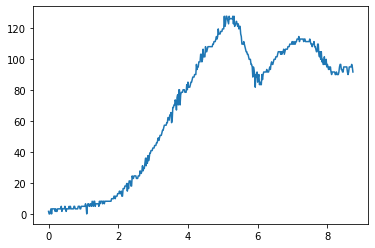

In [36]:
fig, ax = plt.subplots(1)
ax.plot(df['time'], df['normalized height'])
plt.show()

In [37]:
def create_gif(img_dir, crop_area, min_area, df):
    img_paths = sorted(img_dir.glob("*"))

    out_path = Path(".") / "gif"
    out_path.mkdir(exist_ok=True, parents=True)

    for i, f in enumerate(img_paths):
        fig, ax = plt.subplots(1, 4, figsize=(12,4))

        ax[3].plot(df['time'], df['normalized height'])
        ax[3].set_ylabel('Normalized Growth (%)')
        ax[3].set_xlabel('Time (hours)')
        ax[3].plot(df['time'][i], df['normalized height'][i], 'ro')

        height = None

        img = io.imread(f, as_gray=True)
        print(i)
        img_cropped = img[crop_area[0]:crop_area[1], crop_area[2]:crop_area[3]]

        thresh = threshold_minimum(img_cropped)
        binary = img_cropped < thresh
        
        ax[0].imshow(img, cmap='gray')
        ax[1].imshow(img_cropped, cmap='gray')
        ax[2].imshow(binary, cmap='gray')

        label_img = label(binary)
        regions = regionprops(label_img)

        for props in regions:
            y0, x0 = props.centroid

            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc)
            by = (minr, minr)

            area = (maxc-minc)*(maxr-minr)

            if area >= min_area:
                ax[2].plot(bx, by, '-r', linewidth=2.5)
                # ax[2].plot(x0, y0, 'ro')
                height = minr

        for j in range(1,3):
            ax[j].set_yticklabels([])
            ax[j].set_xticklabels([])
            
        ax[0].set_title('Original')
        ax[1].set_title('Cropped')
        ax[2].set_title('Parsed')
        ax[3].set_title('Graphed')
        fig.suptitle("")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        img_out_fpath = out_path / (str(i) + ".jpg")
        fig.savefig(img_out_fpath)
        plt.close(fig)
    


In [38]:
out_path = Path(".") / "gif"
# images = list(map(lambda filename: imageio.imread(filename), sorted(out_path.glob("*"))))
# imageio.mimsave(str(out_path / "test.gif"), images, duration = 0.1)

In [39]:
a = create_gif(Path("/mnt/open-sourdough/images/1/"),[100,340, 240,400], 5000, df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
frames = [Image.open(image) for image in sorted(out_path.glob("*"), key=lambda x: int(x.stem))][0::5]
frame_one = frames[0]
frame_one.save("my_awesome.gif", format="GIF", append_images=frames,
           save_all=True, duration=60, loop=0)
